# Mini Project: Dermatologist AI from Udacity
### Machine Learning Engineer nanodegree

Introduction

In this mini project, you will design an algorithm that can visually diagnose melanoma, the deadliest form of skin cancer. In particular, your algorithm will distinguish this malignant skin tumor from two types of benign lesions (nevi and seborrheic keratoses).

The data and objective are pulled from the 2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection. As part of the challenge, participants were tasked to design an algorithm to diagnose skin lesion images as one of three different skin diseases (melanoma, nevus, or seborrheic keratosis). In this project, you will create a model to generate your own predictions.

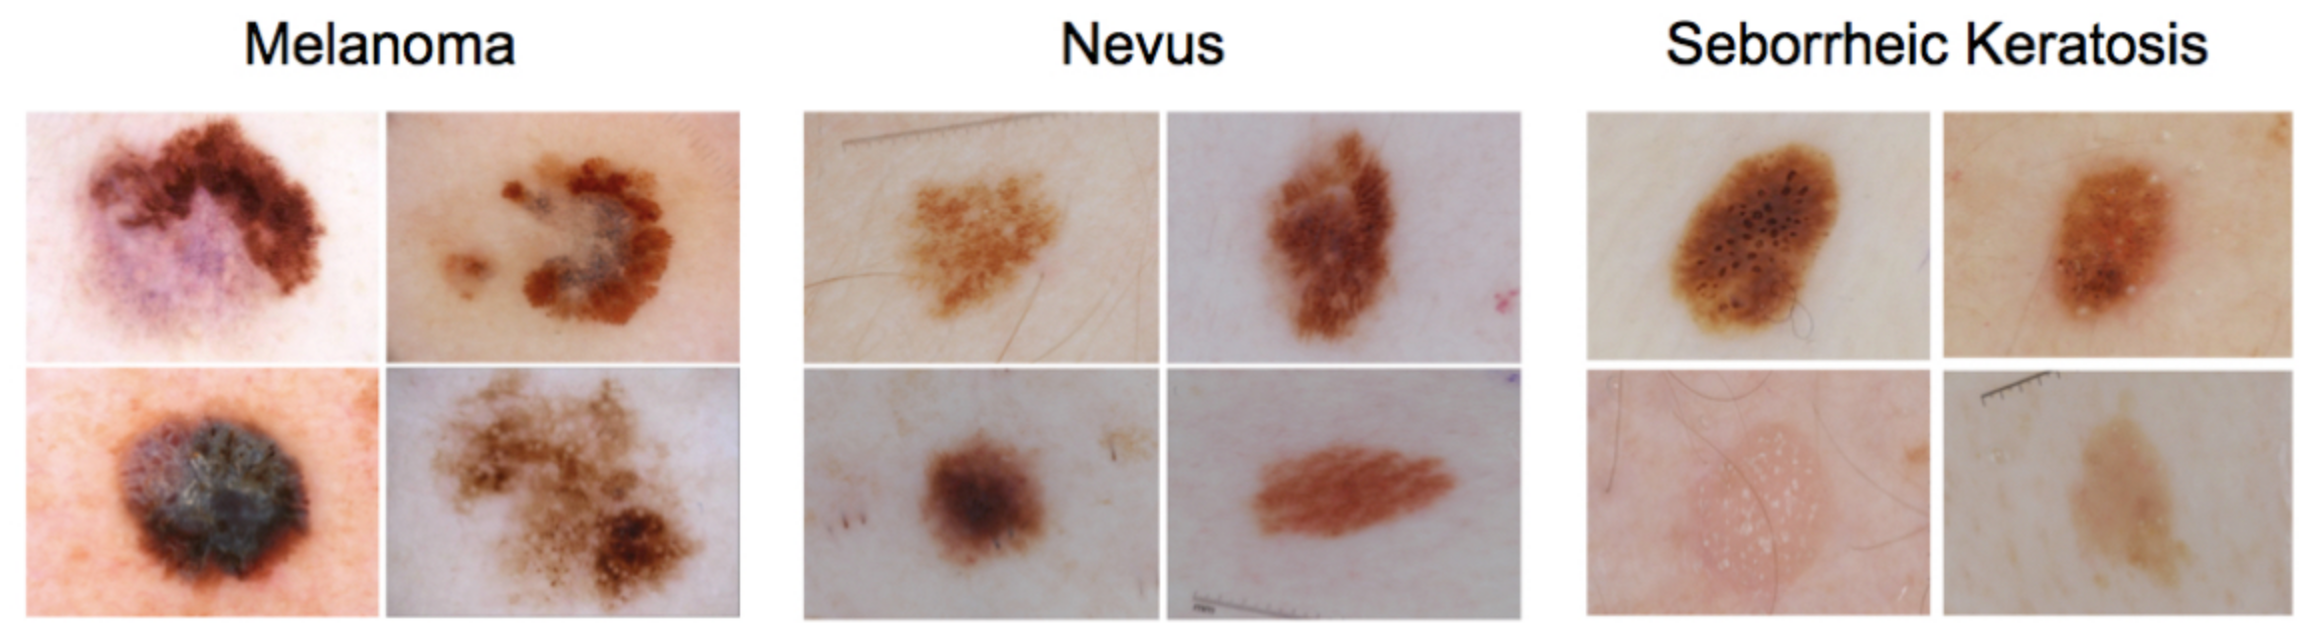


### Imports

In [34]:
import os
import time
import csv
import numpy as np
from glob import glob
from tqdm import tqdm

from sklearn.datasets import load_files

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.utils import np_utils
from keras.layers import Conv2D, Dropout, Flatten, Dense, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras import optimizers

import matplotlib.pyplot as plt

%matplotlib inline

### Helper functions to load the data

In [2]:
def load_dataset(data_path, shuffle=None):
    kwargs = {}
    if shuffle != None:
        kwargs['shuffle'] = shuffle

    data = load_files(data_path, **kwargs)
    image_files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 3)
    
    return image_files, targets

def path_to_tensor(image_path):
    img = image.load_img(image_path, target_size=(384, 256))
    x = image.img_to_array(img)

    return np.expand_dims(x, axis=0)

def paths_to_tensor(image_paths):
    return np.vstack([path_to_tensor(path) for path in image_paths])

### Load the data

In [3]:
train_files, train_targets = load_dataset('data/train', shuffle=True)
valid_files, valid_targets = load_dataset('data/valid', shuffle=True)
test_files, test_targets = load_dataset('data/test', shuffle=False)

# Get lables
labels = [item[11:-1] for item in sorted(glob("data/train/*/"))]

print('train_files size: {}'.format(len(train_files)))
print('train_files shape: {}'.format(train_files.shape))
print('target shape: {}'.format(train_targets.shape))

print("labels:", labels)

train_files size: 2000
train_files shape: (2000,)
target shape: (2000, 3)
labels: ['melanoma', 'nevus', 'seborrheic_keratosis']


### Load the images into tensors

In [4]:
train_tensors = paths_to_tensor(tqdm(train_files))
valid_tensors = paths_to_tensor(tqdm(valid_files))
test_tensors = paths_to_tensor(tqdm(test_files))

print(train_tensors.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [03:29<00:00, 10.60it/s]


(2000, 384, 256, 3)


# Common transformations before the models training

In [5]:
train_tensors_norm = train_tensors.astype('float32') / 255
valid_tensors_norm = valid_tensors.astype('float32') / 255
test_tensors_norm = test_tensors.astype('float32') / 255

In [6]:
print(train_tensors_norm.shape)

(2000, 384, 256, 3)


# CNN Model 1

### Define the model

In [7]:
cnn_model_1 = Sequential()

cnn_model_1.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                       input_shape=train_tensors_norm.shape[1:]))
cnn_model_1.add(MaxPooling2D(pool_size=2))
cnn_model_1.add(Dropout(0.2))

cnn_model_1.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
cnn_model_1.add(MaxPooling2D(pool_size=2))
cnn_model_1.add(Dropout(0.2))

cnn_model_1.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
cnn_model_1.add(MaxPooling2D(pool_size=2))
cnn_model_1.add(Dropout(0.2))

cnn_model_1.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
cnn_model_1.add(MaxPooling2D(pool_size=2))
cnn_model_1.add(Dropout(0.2))

cnn_model_1.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
cnn_model_1.add(MaxPooling2D(pool_size=2))
cnn_model_1.add(Dropout(0.2))

cnn_model_1.add(Conv2D(filters=1024, kernel_size=3, padding='same', activation='relu'))
cnn_model_1.add(MaxPooling2D(pool_size=2))
cnn_model_1.add(Dropout(0.2))

cnn_model_1.add(GlobalAveragePooling2D())

cnn_model_1.add(Dense(3, activation='softmax'))

cnn_model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 384, 256, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 192, 128, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 192, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 192, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 96, 64, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 96, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 64, 128)       73856     
__________

### Compile the model

In [8]:
cnn_model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Add checkpoint

In [9]:
cnn1_checkpoint_path = 'models/cnn1_best_weights.hdf5'

cnn1_checkpointer = ModelCheckpoint(filepath=cnn1_checkpoint_path, verbose=1, save_best_only=True)

### Fit the model

In [10]:
epochs = 100
batch_size = 100

start_time = time.time() 
cnn_model_1.fit(train_tensors_norm, train_targets,
               validation_data=(valid_tensors_norm, valid_targets),
               epochs=epochs, batch_size=batch_size, callbacks=[cnn1_checkpointer], verbose=1)

end_time = time.time()
print("Training completed in: ", end_time - start_time)

Train on 2000 samples, validate on 150 samples
Epoch 1/100
2000/2000 [==============================] - ETA: 1:32 - loss: 1.2458 - acc: 0.160 - ETA: 46s - loss: 2.1003 - acc: 0.430 - ETA: 31s - loss: 1.6635 - acc: 0.53 - ETA: 23s - loss: 1.4826 - acc: 0.58 - ETA: 18s - loss: 1.3875 - acc: 0.62 - ETA: 15s - loss: 1.3298 - acc: 0.63 - ETA: 12s - loss: 1.2891 - acc: 0.63 - ETA: 10s - loss: 1.2575 - acc: 0.64 - ETA: 9s - loss: 1.2303 - acc: 0.6511 - ETA: 7s - loss: 1.2057 - acc: 0.654 - ETA: 6s - loss: 1.1815 - acc: 0.659 - ETA: 5s - loss: 1.1598 - acc: 0.657 - ETA: 4s - loss: 1.1362 - acc: 0.656 - ETA: 3s - loss: 1.1231 - acc: 0.657 - ETA: 3s - loss: 1.0990 - acc: 0.662 - ETA: 2s - loss: 1.0916 - acc: 0.658 - ETA: 1s - loss: 1.0724 - acc: 0.662 - ETA: 1s - loss: 1.0615 - acc: 0.661 - ETA: 0s - loss: 1.0507 - acc: 0.662 - 12s 6ms/step - loss: 1.0427 - acc: 0.6615 - val_loss: 1.0402 - val_acc: 0.5200

Epoch 00001: val_loss improved from inf to 1.04017, saving model to models/cnn1_best_weigh

2000/2000 [==============================] - ETA: 6s - loss: 0.7807 - acc: 0.740 - ETA: 6s - loss: 0.7950 - acc: 0.730 - ETA: 5s - loss: 0.8071 - acc: 0.706 - ETA: 5s - loss: 0.8176 - acc: 0.690 - ETA: 4s - loss: 0.8276 - acc: 0.682 - ETA: 4s - loss: 0.8249 - acc: 0.680 - ETA: 4s - loss: 0.8382 - acc: 0.674 - ETA: 3s - loss: 0.8419 - acc: 0.667 - ETA: 3s - loss: 0.8321 - acc: 0.674 - ETA: 3s - loss: 0.8341 - acc: 0.673 - ETA: 2s - loss: 0.8323 - acc: 0.675 - ETA: 2s - loss: 0.8317 - acc: 0.675 - ETA: 2s - loss: 0.8242 - acc: 0.678 - ETA: 1s - loss: 0.8140 - acc: 0.684 - ETA: 1s - loss: 0.8105 - acc: 0.686 - ETA: 1s - loss: 0.8179 - acc: 0.685 - ETA: 1s - loss: 0.8189 - acc: 0.684 - ETA: 0s - loss: 0.8142 - acc: 0.687 - ETA: 0s - loss: 0.8148 - acc: 0.686 - 7s 3ms/step - loss: 0.8157 - acc: 0.6860 - val_loss: 0.9967 - val_acc: 0.5200

Epoch 00009: val_loss did not improve from 0.97646
Epoch 10/100
2000/2000 [==============================] - ETA: 6s - loss: 0.8658 - acc: 0.650 - ETA: 6s

Epoch 00017: val_loss improved from 0.96196 to 0.95736, saving model to models/cnn1_best_weights.hdf5
Epoch 18/100
2000/2000 [==============================] - ETA: 6s - loss: 0.9105 - acc: 0.620 - ETA: 5s - loss: 0.8085 - acc: 0.685 - ETA: 5s - loss: 0.7650 - acc: 0.703 - ETA: 5s - loss: 0.7665 - acc: 0.700 - ETA: 4s - loss: 0.7571 - acc: 0.708 - ETA: 4s - loss: 0.7690 - acc: 0.703 - ETA: 4s - loss: 0.7734 - acc: 0.698 - ETA: 3s - loss: 0.7822 - acc: 0.691 - ETA: 3s - loss: 0.7762 - acc: 0.695 - ETA: 3s - loss: 0.7806 - acc: 0.692 - ETA: 2s - loss: 0.7839 - acc: 0.690 - ETA: 2s - loss: 0.7806 - acc: 0.689 - ETA: 2s - loss: 0.7823 - acc: 0.688 - ETA: 1s - loss: 0.7726 - acc: 0.695 - ETA: 1s - loss: 0.7728 - acc: 0.692 - ETA: 1s - loss: 0.7711 - acc: 0.693 - ETA: 0s - loss: 0.7784 - acc: 0.688 - ETA: 0s - loss: 0.7731 - acc: 0.692 - ETA: 0s - loss: 0.7742 - acc: 0.692 - 7s 3ms/step - loss: 0.7744 - acc: 0.6890 - val_loss: 0.9267 - val_acc: 0.5200

Epoch 00018: val_loss improved from 0.9

2000/2000 [==============================] - ETA: 6s - loss: 0.7676 - acc: 0.670 - ETA: 6s - loss: 0.7786 - acc: 0.650 - ETA: 5s - loss: 0.7670 - acc: 0.670 - ETA: 5s - loss: 0.8116 - acc: 0.645 - ETA: 4s - loss: 0.7873 - acc: 0.668 - ETA: 4s - loss: 0.7827 - acc: 0.670 - ETA: 4s - loss: 0.7835 - acc: 0.664 - ETA: 3s - loss: 0.7749 - acc: 0.673 - ETA: 3s - loss: 0.7564 - acc: 0.684 - ETA: 3s - loss: 0.7628 - acc: 0.677 - ETA: 2s - loss: 0.7576 - acc: 0.678 - ETA: 2s - loss: 0.7557 - acc: 0.681 - ETA: 2s - loss: 0.7502 - acc: 0.686 - ETA: 1s - loss: 0.7451 - acc: 0.688 - ETA: 1s - loss: 0.7428 - acc: 0.691 - ETA: 1s - loss: 0.7392 - acc: 0.691 - ETA: 0s - loss: 0.7424 - acc: 0.688 - ETA: 0s - loss: 0.7450 - acc: 0.686 - ETA: 0s - loss: 0.7408 - acc: 0.690 - 7s 3ms/step - loss: 0.7424 - acc: 0.6870 - val_loss: 0.8503 - val_acc: 0.5267

Epoch 00026: val_loss improved from 0.87136 to 0.85033, saving model to models/cnn1_best_weights.hdf5
Epoch 27/100
2000/2000 [============================

2000/2000 [==============================] - ETA: 6s - loss: 0.6967 - acc: 0.700 - ETA: 5s - loss: 0.7587 - acc: 0.660 - ETA: 5s - loss: 0.7410 - acc: 0.676 - ETA: 5s - loss: 0.7599 - acc: 0.675 - ETA: 4s - loss: 0.7463 - acc: 0.682 - ETA: 4s - loss: 0.7464 - acc: 0.680 - ETA: 4s - loss: 0.7475 - acc: 0.687 - ETA: 3s - loss: 0.7673 - acc: 0.675 - ETA: 3s - loss: 0.7649 - acc: 0.678 - ETA: 3s - loss: 0.7539 - acc: 0.690 - ETA: 2s - loss: 0.7581 - acc: 0.689 - ETA: 2s - loss: 0.7531 - acc: 0.695 - ETA: 2s - loss: 0.7450 - acc: 0.698 - ETA: 1s - loss: 0.7352 - acc: 0.702 - ETA: 1s - loss: 0.7457 - acc: 0.700 - ETA: 1s - loss: 0.7430 - acc: 0.700 - ETA: 0s - loss: 0.7447 - acc: 0.700 - ETA: 0s - loss: 0.7484 - acc: 0.698 - ETA: 0s - loss: 0.7531 - acc: 0.699 - 7s 3ms/step - loss: 0.7525 - acc: 0.7005 - val_loss: 0.9139 - val_acc: 0.5200

Epoch 00034: val_loss did not improve from 0.82510
Epoch 35/100
2000/2000 [==============================] - ETA: 6s - loss: 0.6543 - acc: 0.760 - ETA: 5s

2000/2000 [==============================] - ETA: 6s - loss: 0.6354 - acc: 0.740 - ETA: 5s - loss: 0.6646 - acc: 0.700 - ETA: 5s - loss: 0.6407 - acc: 0.726 - ETA: 5s - loss: 0.6305 - acc: 0.725 - ETA: 4s - loss: 0.6223 - acc: 0.730 - ETA: 4s - loss: 0.6391 - acc: 0.726 - ETA: 4s - loss: 0.6388 - acc: 0.728 - ETA: 3s - loss: 0.6357 - acc: 0.732 - ETA: 3s - loss: 0.6368 - acc: 0.734 - ETA: 3s - loss: 0.6353 - acc: 0.731 - ETA: 2s - loss: 0.6382 - acc: 0.731 - ETA: 2s - loss: 0.6401 - acc: 0.726 - ETA: 2s - loss: 0.6482 - acc: 0.721 - ETA: 1s - loss: 0.6479 - acc: 0.723 - ETA: 1s - loss: 0.6522 - acc: 0.723 - ETA: 1s - loss: 0.6513 - acc: 0.725 - ETA: 0s - loss: 0.6545 - acc: 0.723 - ETA: 0s - loss: 0.6607 - acc: 0.718 - ETA: 0s - loss: 0.6591 - acc: 0.721 - 7s 3ms/step - loss: 0.6592 - acc: 0.7195 - val_loss: 0.7518 - val_acc: 0.6067

Epoch 00042: val_loss did not improve from 0.72534
Epoch 43/100
2000/2000 [==============================] - ETA: 6s - loss: 0.6932 - acc: 0.720 - ETA: 5s


Epoch 00050: val_loss did not improve from 0.70510
Epoch 51/100
2000/2000 [==============================] - ETA: 6s - loss: 0.6946 - acc: 0.630 - ETA: 5s - loss: 0.6382 - acc: 0.680 - ETA: 5s - loss: 0.6322 - acc: 0.686 - ETA: 5s - loss: 0.6272 - acc: 0.690 - ETA: 4s - loss: 0.6074 - acc: 0.708 - ETA: 4s - loss: 0.5945 - acc: 0.721 - ETA: 4s - loss: 0.6065 - acc: 0.724 - ETA: 3s - loss: 0.5997 - acc: 0.730 - ETA: 3s - loss: 0.5963 - acc: 0.735 - ETA: 3s - loss: 0.5884 - acc: 0.742 - ETA: 2s - loss: 0.5871 - acc: 0.745 - ETA: 2s - loss: 0.5930 - acc: 0.745 - ETA: 2s - loss: 0.5874 - acc: 0.747 - ETA: 1s - loss: 0.5883 - acc: 0.747 - ETA: 1s - loss: 0.5962 - acc: 0.742 - ETA: 1s - loss: 0.6039 - acc: 0.741 - ETA: 0s - loss: 0.6098 - acc: 0.737 - ETA: 0s - loss: 0.6094 - acc: 0.735 - ETA: 0s - loss: 0.6112 - acc: 0.736 - 7s 3ms/step - loss: 0.6118 - acc: 0.7370 - val_loss: 0.7190 - val_acc: 0.7000

Epoch 00051: val_loss did not improve from 0.70510
Epoch 52/100
2000/2000 [==============

2000/2000 [==============================] - ETA: 6s - loss: 0.5624 - acc: 0.760 - ETA: 5s - loss: 0.5583 - acc: 0.745 - ETA: 5s - loss: 0.5893 - acc: 0.730 - ETA: 5s - loss: 0.5728 - acc: 0.752 - ETA: 4s - loss: 0.5642 - acc: 0.752 - ETA: 4s - loss: 0.5521 - acc: 0.760 - ETA: 4s - loss: 0.5360 - acc: 0.767 - ETA: 3s - loss: 0.5317 - acc: 0.771 - ETA: 3s - loss: 0.5472 - acc: 0.770 - ETA: 3s - loss: 0.5465 - acc: 0.774 - ETA: 2s - loss: 0.5336 - acc: 0.775 - ETA: 2s - loss: 0.5300 - acc: 0.777 - ETA: 2s - loss: 0.5306 - acc: 0.780 - ETA: 1s - loss: 0.5317 - acc: 0.775 - ETA: 1s - loss: 0.5382 - acc: 0.770 - ETA: 1s - loss: 0.5323 - acc: 0.771 - ETA: 0s - loss: 0.5345 - acc: 0.772 - ETA: 0s - loss: 0.5362 - acc: 0.771 - ETA: 0s - loss: 0.5402 - acc: 0.771 - 7s 3ms/step - loss: 0.5465 - acc: 0.7690 - val_loss: 0.7726 - val_acc: 0.6267

Epoch 00059: val_loss did not improve from 0.67541
Epoch 60/100
2000/2000 [==============================] - ETA: 6s - loss: 0.4654 - acc: 0.820 - ETA: 5s

2000/2000 [==============================] - ETA: 6s - loss: 0.4573 - acc: 0.780 - ETA: 5s - loss: 0.5093 - acc: 0.760 - ETA: 5s - loss: 0.4852 - acc: 0.766 - ETA: 5s - loss: 0.4845 - acc: 0.775 - ETA: 4s - loss: 0.4866 - acc: 0.770 - ETA: 4s - loss: 0.4733 - acc: 0.783 - ETA: 4s - loss: 0.4456 - acc: 0.798 - ETA: 3s - loss: 0.4484 - acc: 0.801 - ETA: 3s - loss: 0.4452 - acc: 0.803 - ETA: 3s - loss: 0.4472 - acc: 0.802 - ETA: 2s - loss: 0.4550 - acc: 0.798 - ETA: 2s - loss: 0.4499 - acc: 0.801 - ETA: 2s - loss: 0.4450 - acc: 0.805 - ETA: 1s - loss: 0.4385 - acc: 0.807 - ETA: 1s - loss: 0.4373 - acc: 0.812 - ETA: 1s - loss: 0.4444 - acc: 0.809 - ETA: 0s - loss: 0.4419 - acc: 0.810 - ETA: 0s - loss: 0.4448 - acc: 0.807 - ETA: 0s - loss: 0.4451 - acc: 0.807 - 7s 3ms/step - loss: 0.4438 - acc: 0.8080 - val_loss: 0.9220 - val_acc: 0.6467

Epoch 00068: val_loss did not improve from 0.67541
Epoch 69/100
2000/2000 [==============================] - ETA: 6s - loss: 0.4077 - acc: 0.840 - ETA: 5s

2000/2000 [==============================] - ETA: 6s - loss: 0.3645 - acc: 0.870 - ETA: 6s - loss: 0.3328 - acc: 0.880 - ETA: 5s - loss: 0.3059 - acc: 0.890 - ETA: 5s - loss: 0.2769 - acc: 0.907 - ETA: 4s - loss: 0.2739 - acc: 0.904 - ETA: 4s - loss: 0.2716 - acc: 0.901 - ETA: 4s - loss: 0.2787 - acc: 0.894 - ETA: 3s - loss: 0.3018 - acc: 0.888 - ETA: 3s - loss: 0.3208 - acc: 0.885 - ETA: 3s - loss: 0.3138 - acc: 0.887 - ETA: 2s - loss: 0.3122 - acc: 0.885 - ETA: 2s - loss: 0.3202 - acc: 0.882 - ETA: 2s - loss: 0.3178 - acc: 0.881 - ETA: 1s - loss: 0.3178 - acc: 0.880 - ETA: 1s - loss: 0.3144 - acc: 0.884 - ETA: 1s - loss: 0.3128 - acc: 0.881 - ETA: 0s - loss: 0.3155 - acc: 0.878 - ETA: 0s - loss: 0.3155 - acc: 0.878 - ETA: 0s - loss: 0.3148 - acc: 0.878 - 7s 3ms/step - loss: 0.3108 - acc: 0.8795 - val_loss: 1.1423 - val_acc: 0.6333

Epoch 00077: val_loss did not improve from 0.67541
Epoch 78/100
2000/2000 [==============================] - ETA: 6s - loss: 0.3145 - acc: 0.890 - ETA: 5s

2000/2000 [==============================] - ETA: 6s - loss: 0.1666 - acc: 0.930 - ETA: 5s - loss: 0.1375 - acc: 0.940 - ETA: 5s - loss: 0.1644 - acc: 0.936 - ETA: 5s - loss: 0.1727 - acc: 0.937 - ETA: 4s - loss: 0.1883 - acc: 0.928 - ETA: 4s - loss: 0.1936 - acc: 0.923 - ETA: 4s - loss: 0.1821 - acc: 0.927 - ETA: 3s - loss: 0.1773 - acc: 0.930 - ETA: 3s - loss: 0.1754 - acc: 0.931 - ETA: 3s - loss: 0.1898 - acc: 0.928 - ETA: 2s - loss: 0.1844 - acc: 0.930 - ETA: 2s - loss: 0.1868 - acc: 0.928 - ETA: 2s - loss: 0.1855 - acc: 0.929 - ETA: 1s - loss: 0.1847 - acc: 0.929 - ETA: 1s - loss: 0.2015 - acc: 0.922 - ETA: 1s - loss: 0.1970 - acc: 0.923 - ETA: 0s - loss: 0.2002 - acc: 0.920 - ETA: 0s - loss: 0.2058 - acc: 0.918 - ETA: 0s - loss: 0.2104 - acc: 0.916 - 7s 3ms/step - loss: 0.2114 - acc: 0.9165 - val_loss: 1.4239 - val_acc: 0.6467

Epoch 00086: val_loss did not improve from 0.67541
Epoch 87/100
2000/2000 [==============================] - ETA: 6s - loss: 0.3245 - acc: 0.870 - ETA: 5s

2000/2000 [==============================] - ETA: 6s - loss: 0.0523 - acc: 0.980 - ETA: 5s - loss: 0.1249 - acc: 0.950 - ETA: 5s - loss: 0.1281 - acc: 0.946 - ETA: 5s - loss: 0.1234 - acc: 0.950 - ETA: 4s - loss: 0.1314 - acc: 0.944 - ETA: 4s - loss: 0.1284 - acc: 0.945 - ETA: 4s - loss: 0.1347 - acc: 0.942 - ETA: 3s - loss: 0.1482 - acc: 0.936 - ETA: 3s - loss: 0.1426 - acc: 0.937 - ETA: 3s - loss: 0.1386 - acc: 0.938 - ETA: 2s - loss: 0.1516 - acc: 0.932 - ETA: 2s - loss: 0.1583 - acc: 0.932 - ETA: 2s - loss: 0.1582 - acc: 0.933 - ETA: 1s - loss: 0.1533 - acc: 0.935 - ETA: 1s - loss: 0.1476 - acc: 0.938 - ETA: 1s - loss: 0.1569 - acc: 0.937 - ETA: 0s - loss: 0.1553 - acc: 0.939 - ETA: 0s - loss: 0.1572 - acc: 0.940 - ETA: 0s - loss: 0.1581 - acc: 0.939 - 7s 3ms/step - loss: 0.1612 - acc: 0.9380 - val_loss: 1.4105 - val_acc: 0.6600

Epoch 00095: val_loss did not improve from 0.67541
Epoch 96/100
2000/2000 [==============================] - ETA: 6s - loss: 0.1476 - acc: 0.940 - ETA: 5s

### Predictions

In [11]:
cnn_model_1_predictions = [cnn_model_1.predict(np.expand_dims(feature, axis=0)) for feature in test_tensors_norm]

In [12]:
cnn_model_1_csv_path = 'cnn_model_1.csv'

with open(cnn_model_1_csv_path, 'w', newline='') as csvfile:
    result_writger = csv.writer(csvfile)
    result_writger.writerow(['Id', 'task_1', 'task_2'])
    for test_filepath, test_prediction in zip(test_files, cnn_model_1_predictions):
        result_writger.writerow([test_filepath, test_prediction[0][0], test_prediction[0][2]])

get_results.py:90: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_true = truth.as_matrix(columns=["task_1", "task_2"])
get_results.py:94: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])


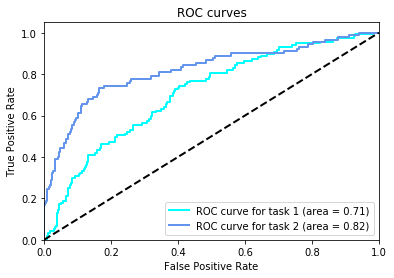

Category 1 Score: 0.708
Category 2 Score: 0.818
Category 3 Score: 0.763


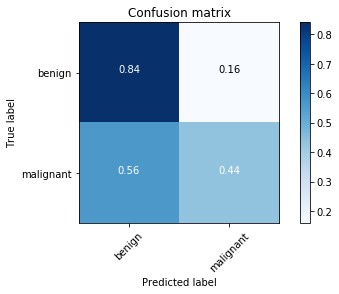

In [13]:
%run -i get_results cnn_model_1.csv 0.4

# CNN Model 2

In [30]:
cnn_model_2 = Sequential()

cnn_model_2.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                       input_shape=train_tensors_norm.shape[1:]))
cnn_model_2.add(MaxPooling2D(pool_size=2))
cnn_model_2.add(Dropout(0.2))

cnn_model_2.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
cnn_model_2.add(MaxPooling2D(pool_size=2))
cnn_model_2.add(Dropout(0.2))

cnn_model_2.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
cnn_model_2.add(MaxPooling2D(pool_size=2))
cnn_model_2.add(Dropout(0.2))

cnn_model_2.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
cnn_model_2.add(MaxPooling2D(pool_size=2))
cnn_model_2.add(Dropout(0.2))

cnn_model_2.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
cnn_model_2.add(MaxPooling2D(pool_size=2))
cnn_model_2.add(Dropout(0.2))

cnn_model_2.add(Conv2D(filters=1024, kernel_size=3, padding='same', activation='relu'))
cnn_model_2.add(MaxPooling2D(pool_size=2))
cnn_model_2.add(Dropout(0.2))

cnn_model_2.add(Flatten())

cnn_model_2.add(Dense(512, activation='relu'))
cnn_model_2.add(Dropout(0.2))

cnn_model_2.add(Dense(3, activation='softmax'))

cnn_model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 384, 256, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 192, 128, 32)      0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 192, 128, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 192, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 96, 64, 64)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 96, 64, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 96, 64, 128)       73856     
__________

### Compile the model

In [44]:
optimizer = optimizers.adagrad(lr=0.01)
cnn_model_2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Add checkpoint

In [45]:
cnn2_checkpoint_path = 'models/cnn2_best_weights.hdf5'

cnn2_checkpointer = ModelCheckpoint(filepath=cnn2_checkpoint_path, verbose=1, save_best_only=True)

### Fit the model

In [46]:
epochs = 100
batch_size = 100

start_time = time.time() 
cnn_model_2.fit(train_tensors_norm, train_targets,
               validation_data=(valid_tensors_norm, valid_targets),
               epochs=epochs, batch_size=batch_size, callbacks=[cnn2_checkpointer], verbose=1)

end_time = time.time()
print("Training completed in: ", end_time - start_time)

Train on 2000 samples, validate on 150 samples
Epoch 1/100
2000/2000 [==============================] - ETA: 33s - loss: 5.4802 - acc: 0.66 - ETA: 19s - loss: 5.3996 - acc: 0.66 - ETA: 13s - loss: 5.3190 - acc: 0.67 - ETA: 11s - loss: 5.0772 - acc: 0.68 - ETA: 9s - loss: 5.0288 - acc: 0.6880 - ETA: 8s - loss: 5.0503 - acc: 0.686 - ETA: 7s - loss: 5.2269 - acc: 0.675 - ETA: 6s - loss: 5.1578 - acc: 0.680 - ETA: 5s - loss: 5.0503 - acc: 0.686 - ETA: 4s - loss: 5.0450 - acc: 0.687 - ETA: 4s - loss: 5.0992 - acc: 0.683 - ETA: 3s - loss: 5.0235 - acc: 0.688 - ETA: 3s - loss: 4.9718 - acc: 0.691 - ETA: 2s - loss: 5.0542 - acc: 0.686 - ETA: 2s - loss: 5.1470 - acc: 0.680 - ETA: 1s - loss: 5.0671 - acc: 0.685 - ETA: 1s - loss: 5.1578 - acc: 0.680 - ETA: 0s - loss: 5.1220 - acc: 0.682 - ETA: 0s - loss: 5.1493 - acc: 0.680 - 9s 4ms/step - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200

Epoch 00001: val_loss improved from inf to 7.73669, saving model to models/cnn2_best_weights.h


Epoch 00009: val_loss did not improve from 7.73669
Epoch 10/100
2000/2000 [==============================] - ETA: 6s - loss: 4.1907 - acc: 0.740 - ETA: 6s - loss: 4.5131 - acc: 0.720 - ETA: 5s - loss: 4.9966 - acc: 0.690 - ETA: 5s - loss: 4.8757 - acc: 0.697 - ETA: 5s - loss: 5.0611 - acc: 0.686 - ETA: 4s - loss: 5.0772 - acc: 0.685 - ETA: 4s - loss: 5.0427 - acc: 0.687 - ETA: 4s - loss: 5.0369 - acc: 0.687 - ETA: 3s - loss: 4.9787 - acc: 0.691 - ETA: 3s - loss: 4.9644 - acc: 0.692 - ETA: 3s - loss: 5.0113 - acc: 0.689 - ETA: 2s - loss: 5.0638 - acc: 0.685 - ETA: 2s - loss: 5.0462 - acc: 0.686 - ETA: 2s - loss: 5.1233 - acc: 0.682 - ETA: 1s - loss: 5.1256 - acc: 0.682 - ETA: 1s - loss: 5.1175 - acc: 0.682 - ETA: 1s - loss: 5.1009 - acc: 0.683 - ETA: 0s - loss: 5.0772 - acc: 0.685 - ETA: 0s - loss: 5.0984 - acc: 0.683 - 7s 3ms/step - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200

Epoch 00010: val_loss did not improve from 7.73669
Epoch 11/100
2000/2000 [==============

Epoch 00018: val_loss did not improve from 7.73669
Epoch 19/100
2000/2000 [==============================] - ETA: 6s - loss: 5.3190 - acc: 0.670 - ETA: 6s - loss: 4.8354 - acc: 0.700 - ETA: 5s - loss: 4.8354 - acc: 0.700 - ETA: 5s - loss: 5.3593 - acc: 0.667 - ETA: 5s - loss: 5.2545 - acc: 0.674 - ETA: 4s - loss: 4.8892 - acc: 0.696 - ETA: 4s - loss: 4.9506 - acc: 0.692 - ETA: 4s - loss: 4.8757 - acc: 0.697 - ETA: 3s - loss: 4.7996 - acc: 0.702 - ETA: 3s - loss: 4.7710 - acc: 0.704 - ETA: 3s - loss: 4.7768 - acc: 0.703 - ETA: 2s - loss: 4.8623 - acc: 0.698 - ETA: 2s - loss: 4.9842 - acc: 0.690 - ETA: 2s - loss: 4.9851 - acc: 0.690 - ETA: 1s - loss: 4.9321 - acc: 0.694 - ETA: 1s - loss: 4.9664 - acc: 0.691 - ETA: 1s - loss: 4.9776 - acc: 0.691 - ETA: 0s - loss: 4.9966 - acc: 0.690 - ETA: 0s - loss: 5.0051 - acc: 0.689 - 7s 4ms/step - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200

Epoch 00019: val_loss did not improve from 7.73669
Epoch 20/100
2000/2000 [===============

Epoch 00027: val_loss did not improve from 7.73669
Epoch 28/100
2000/2000 [==============================] - ETA: 6s - loss: 4.5131 - acc: 0.720 - ETA: 6s - loss: 4.3519 - acc: 0.730 - ETA: 5s - loss: 4.4056 - acc: 0.726 - ETA: 5s - loss: 4.5937 - acc: 0.715 - ETA: 5s - loss: 4.8032 - acc: 0.702 - ETA: 4s - loss: 4.8086 - acc: 0.701 - ETA: 4s - loss: 5.0196 - acc: 0.688 - ETA: 4s - loss: 5.1981 - acc: 0.677 - ETA: 3s - loss: 5.1757 - acc: 0.678 - ETA: 3s - loss: 5.0933 - acc: 0.684 - ETA: 3s - loss: 5.0845 - acc: 0.684 - ETA: 2s - loss: 5.0906 - acc: 0.684 - ETA: 2s - loss: 5.1454 - acc: 0.680 - ETA: 2s - loss: 4.9621 - acc: 0.692 - ETA: 1s - loss: 4.9966 - acc: 0.690 - ETA: 1s - loss: 4.9160 - acc: 0.695 - ETA: 1s - loss: 5.0061 - acc: 0.689 - ETA: 0s - loss: 5.0414 - acc: 0.687 - ETA: 0s - loss: 5.0730 - acc: 0.685 - 7s 3ms/step - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200

Epoch 00028: val_loss did not improve from 7.73669
Epoch 29/100
2000/2000 [===============

Epoch 00036: val_loss did not improve from 7.73669
Epoch 37/100
2000/2000 [==============================] - ETA: 6s - loss: 4.5131 - acc: 0.720 - ETA: 5s - loss: 4.4325 - acc: 0.725 - ETA: 5s - loss: 4.1370 - acc: 0.743 - ETA: 5s - loss: 4.3519 - acc: 0.730 - ETA: 5s - loss: 4.6098 - acc: 0.714 - ETA: 4s - loss: 4.8354 - acc: 0.700 - ETA: 4s - loss: 4.8585 - acc: 0.698 - ETA: 4s - loss: 4.8959 - acc: 0.696 - ETA: 3s - loss: 4.9429 - acc: 0.693 - ETA: 3s - loss: 4.9805 - acc: 0.691 - ETA: 3s - loss: 5.0406 - acc: 0.687 - ETA: 2s - loss: 5.0638 - acc: 0.685 - ETA: 2s - loss: 5.0462 - acc: 0.686 - ETA: 2s - loss: 5.0311 - acc: 0.687 - ETA: 1s - loss: 4.9859 - acc: 0.690 - ETA: 1s - loss: 5.0369 - acc: 0.687 - ETA: 1s - loss: 5.0345 - acc: 0.687 - ETA: 0s - loss: 5.0414 - acc: 0.687 - ETA: 0s - loss: 5.0560 - acc: 0.686 - 7s 3ms/step - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200

Epoch 00037: val_loss did not improve from 7.73669
Epoch 38/100
2000/2000 [===============

Epoch 00045: val_loss did not improve from 7.73669
Epoch 46/100
2000/2000 [==============================] - ETA: 6s - loss: 5.3190 - acc: 0.670 - ETA: 6s - loss: 5.0772 - acc: 0.685 - ETA: 5s - loss: 5.1578 - acc: 0.680 - ETA: 5s - loss: 5.5204 - acc: 0.657 - ETA: 5s - loss: 5.5124 - acc: 0.658 - ETA: 4s - loss: 5.3996 - acc: 0.665 - ETA: 4s - loss: 5.2499 - acc: 0.674 - ETA: 4s - loss: 5.2988 - acc: 0.671 - ETA: 3s - loss: 5.1757 - acc: 0.678 - ETA: 3s - loss: 5.1739 - acc: 0.679 - ETA: 3s - loss: 5.2457 - acc: 0.674 - ETA: 2s - loss: 5.0772 - acc: 0.685 - ETA: 2s - loss: 4.9222 - acc: 0.694 - ETA: 2s - loss: 4.9390 - acc: 0.693 - ETA: 1s - loss: 5.0288 - acc: 0.688 - ETA: 1s - loss: 5.0873 - acc: 0.684 - ETA: 1s - loss: 5.0725 - acc: 0.685 - ETA: 0s - loss: 5.1130 - acc: 0.682 - ETA: 0s - loss: 5.1154 - acc: 0.682 - 7s 4ms/step - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200

Epoch 00046: val_loss did not improve from 7.73669
Epoch 47/100
2000/2000 [===============

Epoch 00054: val_loss did not improve from 7.73669
Epoch 55/100
2000/2000 [==============================] - ETA: 6s - loss: 3.7072 - acc: 0.770 - ETA: 6s - loss: 4.0295 - acc: 0.750 - ETA: 5s - loss: 4.0833 - acc: 0.746 - ETA: 5s - loss: 4.2310 - acc: 0.737 - ETA: 5s - loss: 4.6420 - acc: 0.712 - ETA: 4s - loss: 4.7817 - acc: 0.703 - ETA: 4s - loss: 4.8354 - acc: 0.700 - ETA: 4s - loss: 4.7951 - acc: 0.702 - ETA: 3s - loss: 4.8175 - acc: 0.701 - ETA: 3s - loss: 4.8999 - acc: 0.696 - ETA: 3s - loss: 4.9673 - acc: 0.691 - ETA: 2s - loss: 4.9966 - acc: 0.690 - ETA: 2s - loss: 5.0462 - acc: 0.686 - ETA: 2s - loss: 5.0657 - acc: 0.685 - ETA: 1s - loss: 5.0503 - acc: 0.686 - ETA: 1s - loss: 5.0571 - acc: 0.686 - ETA: 1s - loss: 5.0345 - acc: 0.687 - ETA: 0s - loss: 5.0772 - acc: 0.685 - ETA: 0s - loss: 5.0814 - acc: 0.684 - 7s 3ms/step - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200

Epoch 00055: val_loss did not improve from 7.73669
Epoch 56/100
2000/2000 [===============

Epoch 00063: val_loss did not improve from 7.73669
Epoch 64/100
2000/2000 [==============================] - ETA: 6s - loss: 4.9966 - acc: 0.690 - ETA: 6s - loss: 5.3996 - acc: 0.665 - ETA: 5s - loss: 5.0503 - acc: 0.686 - ETA: 5s - loss: 4.9563 - acc: 0.692 - ETA: 5s - loss: 4.8677 - acc: 0.698 - ETA: 4s - loss: 5.0503 - acc: 0.686 - ETA: 4s - loss: 4.9966 - acc: 0.690 - ETA: 4s - loss: 5.0571 - acc: 0.686 - ETA: 3s - loss: 5.0324 - acc: 0.687 - ETA: 3s - loss: 5.0772 - acc: 0.685 - ETA: 3s - loss: 5.0992 - acc: 0.683 - ETA: 2s - loss: 5.0503 - acc: 0.686 - ETA: 2s - loss: 5.0834 - acc: 0.684 - ETA: 2s - loss: 5.0311 - acc: 0.687 - ETA: 1s - loss: 5.1041 - acc: 0.683 - ETA: 1s - loss: 5.0369 - acc: 0.687 - ETA: 1s - loss: 5.1009 - acc: 0.683 - ETA: 0s - loss: 5.0951 - acc: 0.683 - ETA: 0s - loss: 5.0814 - acc: 0.684 - 7s 4ms/step - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200

Epoch 00064: val_loss did not improve from 7.73669
Epoch 65/100
2000/2000 [===============

Epoch 00072: val_loss did not improve from 7.73669
Epoch 73/100
2000/2000 [==============================] - ETA: 6s - loss: 4.6742 - acc: 0.710 - ETA: 6s - loss: 5.3190 - acc: 0.670 - ETA: 5s - loss: 5.3727 - acc: 0.666 - ETA: 5s - loss: 5.3593 - acc: 0.667 - ETA: 5s - loss: 5.3834 - acc: 0.666 - ETA: 4s - loss: 5.4264 - acc: 0.663 - ETA: 4s - loss: 5.2959 - acc: 0.671 - ETA: 4s - loss: 5.2182 - acc: 0.676 - ETA: 3s - loss: 5.2294 - acc: 0.675 - ETA: 3s - loss: 5.1094 - acc: 0.683 - ETA: 3s - loss: 5.0406 - acc: 0.687 - ETA: 2s - loss: 5.1041 - acc: 0.683 - ETA: 2s - loss: 5.0338 - acc: 0.687 - ETA: 2s - loss: 5.0887 - acc: 0.684 - ETA: 1s - loss: 5.1363 - acc: 0.681 - ETA: 1s - loss: 5.1074 - acc: 0.683 - ETA: 1s - loss: 5.0535 - acc: 0.686 - ETA: 0s - loss: 4.9787 - acc: 0.691 - ETA: 0s - loss: 5.0390 - acc: 0.687 - 7s 3ms/step - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200

Epoch 00073: val_loss did not improve from 7.73669
Epoch 74/100
2000/2000 [===============

Epoch 00081: val_loss did not improve from 7.73669
Epoch 82/100
2000/2000 [==============================] - ETA: 6s - loss: 5.1578 - acc: 0.680 - ETA: 6s - loss: 5.1578 - acc: 0.680 - ETA: 5s - loss: 5.1041 - acc: 0.683 - ETA: 5s - loss: 4.9160 - acc: 0.695 - ETA: 5s - loss: 4.9966 - acc: 0.690 - ETA: 4s - loss: 4.8623 - acc: 0.698 - ETA: 4s - loss: 4.7894 - acc: 0.702 - ETA: 4s - loss: 4.8959 - acc: 0.696 - ETA: 3s - loss: 4.7996 - acc: 0.702 - ETA: 3s - loss: 4.8354 - acc: 0.700 - ETA: 3s - loss: 4.8794 - acc: 0.697 - ETA: 2s - loss: 4.9026 - acc: 0.695 - ETA: 2s - loss: 4.9346 - acc: 0.693 - ETA: 2s - loss: 5.0657 - acc: 0.685 - ETA: 1s - loss: 5.0933 - acc: 0.684 - ETA: 1s - loss: 5.1779 - acc: 0.678 - ETA: 1s - loss: 5.1104 - acc: 0.682 - ETA: 0s - loss: 5.1041 - acc: 0.683 - ETA: 0s - loss: 5.0645 - acc: 0.685 - 7s 3ms/step - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200

Epoch 00082: val_loss did not improve from 7.73669
Epoch 83/100
2000/2000 [===============

Epoch 00090: val_loss did not improve from 7.73669
Epoch 91/100
2000/2000 [==============================] - ETA: 6s - loss: 5.3190 - acc: 0.670 - ETA: 6s - loss: 4.6742 - acc: 0.710 - ETA: 5s - loss: 4.6742 - acc: 0.710 - ETA: 5s - loss: 4.7548 - acc: 0.705 - ETA: 5s - loss: 4.7387 - acc: 0.706 - ETA: 4s - loss: 4.6474 - acc: 0.711 - ETA: 4s - loss: 4.7433 - acc: 0.705 - ETA: 4s - loss: 4.6944 - acc: 0.708 - ETA: 3s - loss: 4.7101 - acc: 0.707 - ETA: 3s - loss: 4.7710 - acc: 0.704 - ETA: 3s - loss: 4.7915 - acc: 0.702 - ETA: 2s - loss: 5.0235 - acc: 0.688 - ETA: 2s - loss: 5.0710 - acc: 0.685 - ETA: 2s - loss: 5.0311 - acc: 0.687 - ETA: 1s - loss: 4.9966 - acc: 0.690 - ETA: 1s - loss: 5.0168 - acc: 0.688 - ETA: 1s - loss: 5.1009 - acc: 0.683 - ETA: 0s - loss: 5.0593 - acc: 0.686 - ETA: 0s - loss: 5.0560 - acc: 0.686 - 7s 3ms/step - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200

Epoch 00091: val_loss did not improve from 7.73669
Epoch 92/100
2000/2000 [===============

Epoch 00099: val_loss did not improve from 7.73669
Epoch 100/100
2000/2000 [==============================] - ETA: 6s - loss: 5.1578 - acc: 0.680 - ETA: 6s - loss: 4.9966 - acc: 0.690 - ETA: 5s - loss: 5.2115 - acc: 0.676 - ETA: 5s - loss: 5.2384 - acc: 0.675 - ETA: 4s - loss: 5.1256 - acc: 0.682 - ETA: 4s - loss: 5.0235 - acc: 0.688 - ETA: 4s - loss: 5.1808 - acc: 0.678 - ETA: 3s - loss: 5.2384 - acc: 0.675 - ETA: 3s - loss: 5.1757 - acc: 0.678 - ETA: 3s - loss: 5.1578 - acc: 0.680 - ETA: 2s - loss: 5.0113 - acc: 0.689 - ETA: 2s - loss: 4.9966 - acc: 0.690 - ETA: 2s - loss: 5.0586 - acc: 0.686 - ETA: 1s - loss: 5.0887 - acc: 0.684 - ETA: 1s - loss: 5.1578 - acc: 0.680 - ETA: 1s - loss: 5.1477 - acc: 0.680 - ETA: 1s - loss: 5.2147 - acc: 0.676 - ETA: 0s - loss: 5.1309 - acc: 0.681 - ETA: 0s - loss: 5.0899 - acc: 0.684 - 7s 3ms/step - loss: 5.0611 - acc: 0.6860 - val_loss: 7.7367 - val_acc: 0.5200

Epoch 00100: val_loss did not improve from 7.73669
Training completed in:  702.0252351760

### Predictions

In [47]:
cnn_model_2_predictions = [cnn_model_2.predict(np.expand_dims(feature, axis=0)) for feature in test_tensors_norm]

In [48]:
cnn_model_2_csv_path = 'cnn_model_2.csv'

with open(cnn_model_2_csv_path, 'w', newline='') as csvfile:
    result_writger = csv.writer(csvfile)
    result_writger.writerow(['Id', 'task_1', 'task_2'])
    for test_filepath, test_prediction in zip(test_files, cnn_model_2_predictions):
        result_writger.writerow([test_filepath, test_prediction[0][0], test_prediction[0][2]])

get_results.py:90: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_true = truth.as_matrix(columns=["task_1", "task_2"])
get_results.py:94: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])


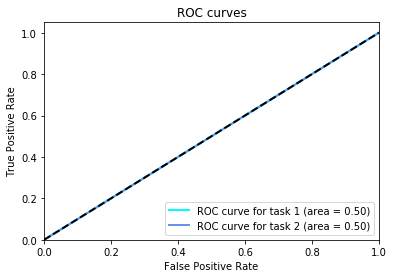

Category 1 Score: 0.500
Category 2 Score: 0.500
Category 3 Score: 0.500


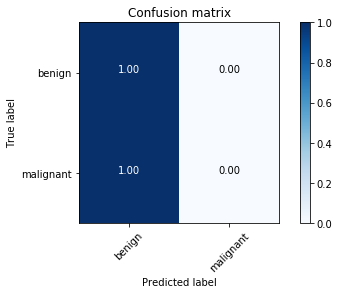

In [49]:
%run -i get_results cnn_model_2.csv 0.4

It seems that replacing the GlobalAveragePooling2D() layer with Dense() layer is making the model worse.